# 特征工程
- 因时间问题，本task与特征工程[动物书]同步进行，故为一个简单demo，后会持续更新
- 因模型还未确定，故认为部分特征需要模型确认后进行微调，将在周末进行完善补充。

## 异常值
- 箱线图（主要处理方式为利用分位数）
- Box-Cox转换（处理偏态分布）
- 长尾截断（偏态分布极值部分，如本次训练集的label）

## 归一化/标准化（无量纲处理）
- 标准化（Z分布）
- 归一化（max-min/区间）
- 冥律分布

## 数据分箱（常见Logstic）
- 等频
- 等距
- Beat-Ks（基尼指数）
- 卡方

## 缺省值
- 忽略
- 删除
- 补全（统计量/算法）
- 分箱
- 对于训练集测试集，测试集缺失值是否以与训练集的值同样填充
## 特征衍生
- 统计量
- 时间序列
- 算法填充
- 别的方法（待研究）
## 降维
- 过滤式
- 包裹式
- 嵌入式
## 特征选择
- PCA/LDA/ICA


In [2]:
# 引入相关模块——贯穿始终

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None) # 设置
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
import time
# 常规数据科学包 pd,np,scipy

warnings.filterwarnings('ignore') # 取消警告
%matplotlib inline 
#内嵌在Notebook中，可以省去plt.show()

In [3]:
Train_data = pd.read_csv('used_car_train_20200313.csv', sep=' ')
Test_data = pd.read_csv('used_car_testA_20200313.csv', sep=' ')
print(Train_data.shape)
print(Test_data.shape)

(150000, 31)
(50000, 30)


## 异常值处理-删除异常值

In [5]:
# 这里我包装了一个异常值处理的代码，可以随便调用。
# 调用别人轮子，加上注释，并做相应的删改
def outliers_proc(data, col_name, scale=3):
    """
    用于清洗异常值，默认用 box_plot（scale=3）进行清洗
    :param data: 接收 pandas 数据格式
    :param col_name: pandas 列名
    :param scale: 尺度
    :return:
    """

    def box_plot_outliers(data_ser, box_scale):
        """
        利用箱线图去除异常值
        :param data_ser: 接收 pandas.Series 数据格式
        :param box_scale: 箱线图尺度，
        :return:
        """
        iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
        val_low = data_ser.quantile(0.25) - iqr
        val_up = data_ser.quantile(0.75) + iqr
        rule_low = (data_ser < val_low)
        rule_up = (data_ser > val_up)
        return (rule_low, rule_up), (val_low, val_up)

    data_n = data.copy()
    data_series = data_n[col_name]
    rule, value = box_plot_outliers(data_series, box_scale=scale)
    index = np.arange(data_series.shape[0])[rule[0] | rule[1]]
    print("Delete number is: {}".format(len(index)))
    data_n = data_n.drop(index)
    data_n.reset_index(drop=True, inplace=True)
    print("Now column number is: {}".format(data_n.shape[0]))
    index_low = np.arange(data_series.shape[0])[rule[0]]
    outliers = data_series.iloc[index_low]
    print("Description of data less than the lower bound is:")
    print(pd.Series(outliers).describe())
    index_up = np.arange(data_series.shape[0])[rule[1]]
    outliers = data_series.iloc[index_up]
    print("Description of data larger than the upper bound is:")
    print(pd.Series(outliers).describe())
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 7))
    sns.boxplot(y=data[col_name], data=data, palette="Set1", ax=ax[0])
    sns.boxplot(y=data_n[col_name], data=data_n, palette="Set1", ax=ax[1])
    return data_n

Delete number is: 963
Now column number is: 149037
Description of data less than the lower bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: power, dtype: float64
Description of data larger than the upper bound is:
count      963.000000
mean       846.836968
std       1929.418081
min        376.000000
25%        400.000000
50%        436.000000
75%        514.000000
max      19312.000000
Name: power, dtype: float64


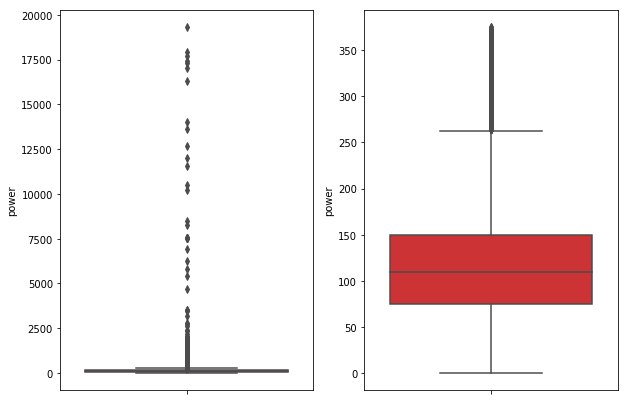

In [6]:
Train_data = outliers_proc(Train_data, 'power', scale=3)

## 部分特征构造

In [8]:
# 训练集和测试集放在一起，方便构造特征
Train_data['train']=1
Test_data['train']=0
data = pd.concat([Train_data, Test_data], ignore_index=True)
# 使用时间：data['creatDate'] - data['regDate']，反应汽车使用时间，一般来说价格与使用时间成反比
# 不过要注意，数据里有时间出错的格式，所以我们需要 errors='coerce'
data['used_time'] = (pd.to_datetime(data['creatDate'], format='%Y%m%d', errors='coerce') - 
                            pd.to_datetime(data['regDate'], format='%Y%m%d', errors='coerce')).dt.days

## 自相关变量筛选

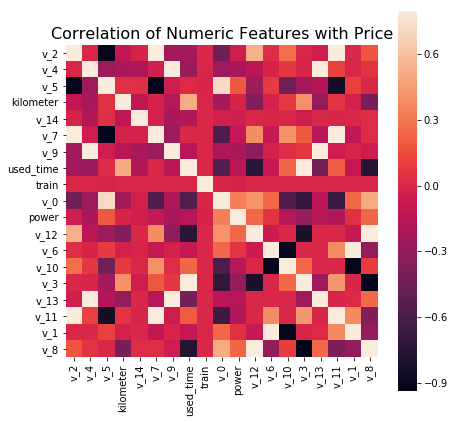

In [10]:
y_label   = ['price']
class_var = ['SaleID','name','regDate','model','brand','bodyType','fuelType','gearbox','notRepairedDamage','regionCode','creatDate','notRepairedDamage','seller','offerType']
numeric_var = list(set(data.columns)-set(class_var)-set(y_label))
data_numeric = data[numeric_var]
correlation = data_numeric.corr()

f , ax = plt.subplots(figsize = (7, 7))
plt.title('Correlation of Numeric Features with Price',y=1,size=16)
sns.heatmap(correlation,square = True,  vmax=0.8)